# <center> Ovarian Cancer Lipidome Dynamics in a _Dicer-Pten_ <br> Double-Knockout Mouse Model </center>


## <center> `Global lipidomic changes` </center>

#### <center>`Olatomiwa O. Bifarin, Ph.D.`</center> <center>Postdoctoral Fellow</center> <center>School of Chemistry & Biochemistry</center> <center>Georgia Institute of Technology </center> <img src="images/GTlogo.png" style="width:100px;height:100px"/> 

# Table of Contents
<a id='0'></a>

1. [Introduction](#1)
    - [Datasets imported and generated in this notebook.](#1.0) 
    - [Dataframe for all (un-annotated) lipidomic features](#1.1)
    - [Data struture descriptions](#1.2)
    - [Import python libraries and primary data](#1.3)
2. [Data wrangling and cleaning](#2)
3. [Distribution of mice's age](#3)
4. [Global significant metabolites](#4)
    - [Significant lipids DKO _vs_ control mice, for all time points combined](#4.1)
    - [Significant lipids DKO _vs_ control mice, for each stage bins](#4.2)
    - [Overlapping significant lipids between stage bins](#4.3)
5. [Global lipidomics changes: unsupervised Learning and PLS-DA.](#5)
    - [PCA](#5.1)
    - [Kernel PCA](#5.2)
    - [Locally linear embeddings](#5.3)
    - [tSNE](#5.4)
    - [uMAP](#5.5)
    - [PLS-DA](#5.6)
6. [Some code references](#6) <br>

## 1. Introduction
<a id='1'></a>

### 1.0 Datasets imported and generated in this notebook. 
<a id='1.0'></a>

**Imported** <br>
1. `before_transpose_dko_unannotated_posmode_all_samples.xlxs`: all metabolic features (annotated and unannotated) from the positive mode of LC-MS analysis. <br>
2. `dko_unannotated_negmode_all_samples.xlsx`: all metabolic features (annotated and unannotated) from the negative mode of LC-MS analysis. <br>
3. `dko_annotated.xlsx`: all annotated metabolic features, contains ~1,000 metabolites. <br>
4. `lipid_compounds_annotated_ids.xlsx`: contains ID and chemical information of the annotated lipid compounds in the study. 

**Generated** <br>
1. `dko_unannotated.csv`: contains all metabolic features (annotated and unannotated) from both positive and negative mode LC-MS. <br>
2. `dko_annotated_updated.xlsx`: that contains updated information on the dataset `dko_annotated.xlsx` after dataframe cleaning. It now includes, but not limited to, columns like lifetime percentages and binned stages.

### 1.1 Dataframe for all (un-annotated) lipidomic features
<a id='1.1'></a>

This section prepares the un-annotated lipidomic feature dataframe by merging the negative and positive mode data. See details below: 


Note: all the transpose operations of other excel files associated with this study were possible with the excel paste-transpose command. However, for the positive mode dataset (`before_transpose_dko_unannotated_posmode_all_samples.xlxs`), it wasn't working because the file is so huge, so I will do the merging operations here in jupyter notebook. It was merged with the negative mode dataset (`dko_unannotated_negmode_all_samples.xlsx`)

The merged, final dko_unnotated datasets (`dko_unannotated.csv`) should be already saved in your local machine. So no need to run the next block of code. If that this apply in your case, please skip to the next session.

In [4]:
#import pandas as pd

# import the original dko un-annotated positive mode datasets
#unannotated_pos = pd.read_excel('data/before_transpose_dko_unannotated_posmode_all_samples.xlsx')

# Transpose
#unannotated_pos1 = unannotated_pos.T

# make ID the header
#unannotated_pos1.columns = unannotated_pos1.iloc[0]

# remove unwanted rows 
#unannotated_pos2 = unannotated_pos1.iloc[9:, :]

# remove QC values.
#unannotated_pos3 = unannotated_pos2.iloc[:459, :]

# reset index. 
#unannotated_pos4 = unannotated_pos3.reset_index()

# drop the column index
#unannotated_pos5 = unannotated_pos4.drop(columns=['index'], axis =1)

# import the transposed un-annotated negative 
#unannotated_neg = pd.read_excel('data/dko_unannotated_negmode_all_samples.xlsx')

#concatenated_dataframes = pd.concat([dataframe1, dataframe2], axis=1)
#final = pd.concat([unannotated_neg, unannotated_pos5], axis=1)

#final.to_csv('dko_unannotated.csv')

### 1.2 Data struture descriptions
<a id='1.2'></a>

**Dataframes** <br>
`df`: The entire study dataframe either annotated or unannotated <br>
`DKOdf`: A subset of DKO dataframe <br>
`controldf`: A subset of control animal dataframe <br>

**Lists or Pandas series** <br>
`features`: all features <br>
`sig_features`: all features with statistical difference (FDR<0.05) between control and DKO for all timepoints combined <br>
`overlap_metabolites`: statistically significant metabolites that overlapped between specific timepoints or binned timepoints.

**Functions** <br>
`Ttest`: Function conducts a T-test for the metabolites differences between two groups with Benjamini-Hocberg FDR correction <br>
`PlotlyPCA`: A principle component analysis function<br>
`PlotlytSNE`: tSNE function <br>
`PlotlyuMAP`: uMAP function <br>
`total_fold_change`: total fold change, all time points combined - log2 fold change (DKO/control) <br>
`timepoint_fold_change`: Function computes the log2 fold change for separate timepoints <br>
`hierarchical_clustering`: Function plots a HCA dendogram, clustering the trajectories of metabolites.<br>
`print_clusters`: Function plots the trajectory of all metabolic clusters<br>
`networkGraph`: An interative network graph for correlation network graph<br>

### 1.3 Import python libraries and primary data
<a id='1.3'></a>

### Library Versions

In [5]:
import matplotlib as mpb
from platform import python_version
import numpy as np
import pandas as pd
import holoviews as hv
import plotly as px
import umap as up
import sklearn as sk
import upsetplot as upset
import scipy as sp
import networkx as nx
import bioinfokit as bio
import lifelines as life

print('Python v.', python_version())
print('Pandas v.', pd.__version__)
print('NumPy v.', np.__version__)
print('Matplotlib v.', mpb.__version__)
print('Holoview v.', hv.__version__)
print('Plotly v.', px.__version__)
print('Statsmodel v.', sms.__version__)
print('UMAP v.', up.__version__)
print('Sklearn v.', sk.__version__)
print('UpsetPlot v.', upset.__version__)
print('Scipy v.', sp.__version__)
print('Networkx v.', nx.__version__)
print('Bioinfokit v.', bio.__version__)
print('Lifeline v.', life.__version__)

Python v. 3.8.8
Pandas v. 1.2.4
NumPy v. 1.20.1
Matplotlib v. 3.3.4
Holoview v. 1.14.6
Plotly v. 5.3.1
Statsmodel v. 0.12.2
UMAP v. 0.5.1
Sklearn v. 0.24.1
UpsetPlot v. 0.6.0
Scipy v. 1.6.2
Networkx v. 2.5
Bioinfokit v. 2.0.8
Lifeline v. 0.26.3


### Import

In [6]:
import numpy as np
import pandas as pd
import scipy
import statsmodels as sms
from statsmodels.stats import multitest

from sklearn import decomposition
from matplotlib import pyplot as plt

import hvplot.pandas 
import holoviews as hv

#For Seaborn plots
import seaborn as sns; sns.set(style='white')

#To ignore warning
import warnings
warnings.filterwarnings('ignore')

# More sharp and legible graphics
%config InlineBackend.figure_format = 'retina'

**Import dataframe for lipid compounds ID**

In [7]:
lipid_compds = pd.read_excel('data/lipid_compounds_annotated_ids.xlsx')

In [8]:
lipid_compds = lipid_compds.iloc[:, 1:]

In [9]:
lipid_compds.head()

,Lipids,ID,RT [min]
0,;;FA(11:2),6,0.998
1,;;FA(11:3),5,1.282
2,;;FA(13:1-OH),28,0.956
3,;;FA(15:0-OH),63,1.025
4,;;FA(15:1-2OH),82,1.012


**Import annotated dataframe**

In [10]:
# import data
df = pd.read_excel('data/dko_annotated.xlsx')
df.head(3)

,id,age,lifetime,death,group,;;FA(11:2),;;FA(11:3),;;FA(13:1-OH),;;FA(15:0-OH),;;FA(15:1-2OH),...,TG(58:9) M + NH3;.1,TG(58:9) M + NH3;.2,TG(58:9) M + NH3;.3,TG(58:9) M + NH3;.4,TG(58:9) M + NH3;.5,TG(58:9) M + NH3;.6,TG(60:3) M + NH3;,ubiquinol(Q10)_M+NH3;,cholesterol derivative,"(2R,3R,4S,5S,6R)-2-{[4-(4-hydroxy-2,6,6-trimethylcyclohex-1-en-1-yl)butan-2-yl]oxy}-6-(hydroxymethyl)oxane-3,4,5-triol;"
0,NC15_T20,46,100.00,46,control,1.055509e+06,496083.464197,459970.994271,961509.006204,3.056176e+06,...,3.385786e+09,2.183883e+08,2.267883e+08,5.409523e+08,3.102343e+09,4.075240e+08,6.375668e+07,9.163258e+06,3.968544e+07,6.712394e+05
1,NC1_T1,8,25.00,32,control,7.127085e+05,226155.712852,353178.631725,534700.310413,1.856627e+06,...,2.622828e+09,2.350839e+08,2.302809e+08,4.992443e+08,2.429847e+09,1.578130e+08,1.521046e+07,1.716687e+07,1.402221e+07,1.170909e+07
2,NC1_T2,10,31.25,32,control,2.990010e+05,117306.345999,119034.602305,261739.346889,7.473977e+05,...,3.418390e+09,3.109862e+08,4.096705e+08,9.708473e+08,3.213337e+09,3.516522e+08,1.018904e+08,1.938169e+07,7.830400e+07,2.999685e+06


**Import unannotated dataframe** <br>
If necessary. 

In [11]:
# import data
#df = pd.read_csv('dko_unannotated.csv')
# remove an unnamed column
#df = df.iloc[:, 1:]
#df.head(3)

### [Go to Table of Contents](#0) <br>

## 2. Data wrangling and cleaning
<a id='2'></a>

In [12]:
# Create a new column with just the sample id (sampl)
df['sampl'] = df['id'].str.split('_').str[0]

# Insert the new column in a location visible with .head() method
df.insert(1, 'sample', df['sampl'].to_list())

# Create a new column with just the timepoint id (timep)
df['timep'] = df['id'].str.split('_').str[1]

# Insert the new column in a location visible with .head() method
df.insert(2, 'timepoint', df['timep'].to_list())

# Drop the unwanted columns at the end of the dataframe
df.drop(['sampl', 'timep'], axis=1, inplace=True)

# Convert timepoint id
df['timepoint'].replace({"T1": "T01", "T2": "T02",
                        "T3": "T03", "T4": "T04", 
                        "T5": "T05", "T6": "T06",
                        "T7": "T07", "T8": "T08",
                        "T9": "T09"}, inplace=True)

# It appears that 'sample' is a dataframe level function that might clash with df.sample
df.rename(columns={'sample':'mice'}, inplace=True)

**Create bins from the % lifetime column.**

<img src="images/computation_design.png" width=700 height=700 />

<div class="alert alert-block alert-success">
Use the pd.cut function to create bins from the % lifetime column <br>

`0, 30, 45, 60, 75, 100` <br>
    
Note: this bins can be customized.<br>
I : 0-30 <br>
II : 30-45 <br>
III : 45-60 <br>
IV : 60-75 <br>
V : 75-100
</div>

In [13]:
# Use the pd.cut function to create bins from the % lifetime dataset
bins=[0, 30, 45, 60, 75, 100]
labels=['I', 'II', 'III', 'IV', 'V']

df['stage_bi'] = pd.cut(df['lifetime'], bins, labels=labels)

# Insert the new column in a location visible with .head() method
df.insert(5, 'stage_bin', df['stage_bi'].to_list())

# Drop the unwanted columns at the end of the dataframe
df.drop(['stage_bi'], axis=1, inplace=True)

In [14]:
df.head()

,id,mice,timepoint,age,lifetime,stage_bin,death,group,;;FA(11:2),;;FA(11:3),...,TG(58:9) M + NH3;.1,TG(58:9) M + NH3;.2,TG(58:9) M + NH3;.3,TG(58:9) M + NH3;.4,TG(58:9) M + NH3;.5,TG(58:9) M + NH3;.6,TG(60:3) M + NH3;,ubiquinol(Q10)_M+NH3;,cholesterol derivative,"(2R,3R,4S,5S,6R)-2-{[4-(4-hydroxy-2,6,6-trimethylcyclohex-1-en-1-yl)butan-2-yl]oxy}-6-(hydroxymethyl)oxane-3,4,5-triol;"
0,NC15_T20,NC15,T20,46,100.00,V,46,control,1.055509e+06,496083.464197,...,3.385786e+09,2.183883e+08,2.267883e+08,5.409523e+08,3.102343e+09,4.075240e+08,6.375668e+07,9.163258e+06,3.968544e+07,6.712394e+05
1,NC1_T1,NC1,T01,8,25.00,I,32,control,7.127085e+05,226155.712852,...,2.622828e+09,2.350839e+08,2.302809e+08,4.992443e+08,2.429847e+09,1.578130e+08,1.521046e+07,1.716687e+07,1.402221e+07,1.170909e+07
2,NC1_T2,NC1,T02,10,31.25,II,32,control,2.990010e+05,117306.345999,...,3.418390e+09,3.109862e+08,4.096705e+08,9.708473e+08,3.213337e+09,3.516522e+08,1.018904e+08,1.938169e+07,7.830400e+07,2.999685e+06
3,NC1_T3,NC1,T03,12,37.50,II,32,control,1.029501e+05,85993.453332,...,1.261545e+09,1.320493e+08,1.402461e+08,2.613283e+08,1.190903e+09,2.856952e+08,2.726481e+07,2.324582e+06,2.186917e+07,2.879285e+06
4,NC1_T4,NC1,T04,14,43.75,II,32,control,2.622025e+05,266760.761103,...,6.118623e+09,5.576515e+08,5.423552e+08,1.040067e+09,5.774111e+09,5.182529e+08,1.783335e+08,2.445218e+07,1.392878e+08,1.226697e+06


Save a new file called `dko_annotated_updated.xlsx` that contains updated information on the dataset after dataframe cleaning. Run code below if needed and see description of key columns afterwards.

In [15]:
#df.to_excel("dko_annotated_updated.xlsx")  


- `id`: refers to the combined `mice` sample id underscore `timepoint`, which are already made to have there own distinctive columns. <br>
- `age`: refers to the age of mice in weeks when blood samples are collected. <br>
- `lifetime`: since mice dies at different times by the effect of ovarian cancer, then % lifetime features is calculated for each sample, where %lifetime is the (age in weeks / total life span or age at death) X 100. <br>
- `stage_bin`: see definition above. <br>
- `death`: refers to the total life span or age at death.

### [Go to Table of Contents](#0) <br>

## 3. Distribution of Mice's Age
<a id='3'></a>

**Distribution of age of mice at death**

In [16]:
df.hvplot.hist(y='death',
               by='group', 
               bins=4, 
               alpha=0.3,
               width=500, height=400,
               xlabel='Age of mice at death',
               ylabel='Frequency',
               legend = 'top',
               title='Histogram Showing Age of Mice at Death')

:NdOverlay   [group]
   :Histogram   [death]   (death_count)

In [17]:
(df[df['group']=='control'].hvplot.hist(y='death', 
                                        bins=4, 
                                        width=300,
                                        title='Control mice age at death(4 bins)') +
 df[df['group']=='DKO'].hvplot.hist(y='death', 
                                    bins=4, 
                                    width=300,
                                    color='tomato',
                                    title='DKO mice age at death (4 bins)'))

:Layout
   .Histogram.I  :Histogram   [death]   (death_count)
   .Histogram.II :Histogram   [death]   (death_count)

**Distribution of the percentage lifetime**

In [18]:
df.hvplot.hist(y='lifetime',
               by='group', 
               bins=5, 
               alpha=0.3,
               width=500, height=400,
               xlabel='% lifetime',
               ylabel='Frequency',
               legend = 'top',
               title='Histogram Showing %lifetime')

:NdOverlay   [group]
   :Histogram   [lifetime]   (lifetime_count)

In [19]:
(df[df['group']=='control'].hvplot.hist(y='lifetime', 
                                        bins=5, 
                                        width=300,
                                        title='Control mice % lifetime (5 bins)') +
 df[df['group']=='DKO'].hvplot.hist(y='lifetime', 
                                    bins=5, 
                                    width=300,
                                    color='tomato',
                                    title='DKO mice % lifetime (5 bins)'))

:Layout
   .Histogram.I  :Histogram   [lifetime]   (lifetime_count)
   .Histogram.II :Histogram   [lifetime]   (lifetime_count)

**Plot similar graph as above for binned stages?**

### [Go to Table of Contents](#0) <br>

## 4. Global significant metabolites
<a id='4'></a>

In this session, the scripts calculate statistical significance of metabolites comparing DKO and control mice
- First for all time points combined, and 
- Next for each time points or stage bins.                                          

**A _T_-test function**

In [20]:
def Ttest(metabolites, dfControl, dfTreat, alpha=0.05, var=True):
    '''
    Function conducts a T-test for the metabolites differences between two groups with 
    Benjamini-Hocberg FDR correction
    
    Inputs: 
    metabolites = A list containing names of metabolites
    dfControl = A pandas dataframe containing the control group metabolites data
    dfTreat =  A pandas dataframe containing the treatment group metabolites data
    alpha = alpha for statistical significant judgment, default 0.05
    var = If True (default), perform a standard independent 2 sample test that assumes 
    equal population variances [1]. If False, perform Welch’s t-test, which does not 
    assume equal population variance
    
    Outputs: A pandas dataframe with p-values of numerical cohort characteristics. 
    
    '''
    ttest_dict = {}
    for metabolite in metabolites:
        statistic, pvalue =  scipy.stats.ttest_ind(dfControl[metabolite], 
                                               dfTreat[metabolite], 
                                               equal_var=var)
        ttest_dict[metabolite] = pvalue 
        # a dictionary containing name of metabolites and p value after t-test
    ttest = pd.DataFrame.from_dict(ttest_dict, orient='index') # the dictionary in pandas df
    ttest_list=list(ttest_dict.values()) #values (pvalues) of ttest result in a list
    reject, pval_corrected, _, _ = sms.stats.multitest.multipletests(ttest_list, 
                                                                 alpha=alpha, 
                                                                 method='fdr_bh')
    ttest_results = pd.DataFrame({'Metabolite': metabolites, 'T-test p-value': ttest_list, 
                              'FDR p-value': pval_corrected, 'Reject H0': reject})
    Table = ttest_results.sort_values(by=['FDR p-value'])
    return Table

**`features` refers to all metabolomic features in the dataframe**

In [21]:
# A list containing all metabolomic `features`
features = df.drop(['id', 'group', 'mice', 
                    'timepoint', 'age',
                    'lifetime', 'stage_bin',
                    'death'], axis=1).columns

How to select only DKO and control dataframe for _t_-test computations.

In [22]:
# How to select only DKO and control dataframe for t-test computations.

# STEP 1: create a dataframe that contains just the group and timepoint, 
# that is, drop id and sample from the non-numeric columns. 

''' df.drop(['id', 'mice'], axis=1) '''

# STEP 2: then create a boolean to select a particular timepoint (e.g. T1). 

''' [df['timepoint']=='T1'] '''

# STEP 3: Split the dataframe into controls vs. DKO.

''' [df['group']=='control']'''

#df.drop(['id', 'mice', 'age', 'lifetime', 'stage_bin', 'death'], axis=1);

control = df.drop(['id', 'mice', 'age', 
                   'lifetime', 'stage_bin', 
                   'death'], axis=1)[df['group']=='control']
DKO = df.drop(['id', 'mice', 'age', 
               'lifetime', 'stage_bin', 
               'death'], axis=1)[df['group']=='DKO']

### 4.1 Significant lipids DKO _vs_ control mice, for all time points combined
<a id='4.1'></a>

In [23]:
print("The total number of DKO mice:", DKO.shape[0])
print("The total number of control:", control.shape[0])

The total number of DKO mice: 221
The total number of control: 238


Given the unequal sample sizes of the two groups to be compared, the Welch _T_ test is used. For the function, please select `var=False`.

In [24]:
# dataframe showing full ttest result.
ttest_result = Ttest(features, control, DKO, alpha=0.05, var=False)

# list of statistically relevant metabolites
# Select metabolites with <0.05 FDR
stat_sig_all = ttest_result.loc[ttest_result['Reject H0'] == True]

# If no significant metabolites were selected using the FDR cut off, 
# select metabolites with p value < 0.05 i.e. the t-test without FDR correction. 
# using the code below. 

'''stat_sig_all = ttest_result.loc[ttest_result['T-test p-value'] <= 0.05]'''

print("The total number of significant lipidomic features is: ", len(stat_sig_all))

# Define a new dataframe with just the significant metabolite
sig_features = stat_sig_all['Metabolite']

The total number of significant lipidomic features is:  87


**`sig_features` refers to all statistical significant metabolomic features in the dataframe (for combined timepoints)**

Here is the list of all the `sig_features`.

In [25]:
sig_features.tolist()

[' PC(O-40:7)>PC(O-18:1/22:6)_and_PC(O-22:7/18:0) M + CH3COOH;;',
 ' PC(O-38:4);PC(O-38:4)',
 ' PC(O-38:4);PC(O-38:4).1',
 ' PC(O-38:4)>PC(O-18:1/20:3) M + CH3COOH;;',
 ' HexCer(d34:1) M + CH3COOH;;',
 ' PC(O-38:5);PC(O-38:5).3',
 ' HexCer(d42:2) M + CH3COOH;;.2',
 ' HexCer(d42:2) M + CH3COOH;;.1',
 ' Prostaglandin A1 ethyl ester;;',
 ' HexCer(d42:2) M + CH3COOH;;',
 ' TG(58:9) M + NH3;.6',
 ' ;FA(14:1);',
 ' Cer(d34:1) M + CH3COOH;;.1',
 ' Cer(d33:1) M + CH3COOH;;',
 ' PC(O-38:5)>PC(O-18:1/20:4)_and_PC(O-38:4)>PC(O-16:0/22:5) M + CH3COOH;;.1',
 ' Cer(d34:1) M + CH3COOH;;',
 ' PC(40:5);PC(40:5).3',
 'FA(16:1);FA(16:1)',
 ' PC(38:4)>PC(18:0_20:4)_2M+H2CO2;;.1',
 ' PI(38:5)>PI(18:1_20:4);PI(38:5);.2',
 ' PC(36:5)>PC(16:0_20:5) M + H2CO2;;.1',
 ' PC(O-32:2)>PC(O-17:1/15:1)_and_PC(O-32:2)>PC(O-16:1/18:1) M + CH3COOH;;',
 ' FA(18:1);FA(18:1);',
 ' PC(O-36:4)>PC(O-16:1/20:3) M + CH3COOH;;',
 ' Cer(d41:2) M + CH3COOH;;',
 ' TG(58:9) M + NH3;.4',
 ' PC(41:6);PC(41:6).2',
 ' PC(41:7);PC(41:7).1

In [26]:
sig_features.tolist();

In [27]:
# Identify lipid IDs. 
sig_features_ID = lipid_compds.loc[lipid_compds['Lipids'].isin(sig_features.tolist())]
#sig_features_ID.to_excel("sig_features_all_timepoints_ID.xlsx")

An histogram plot showing the distribution of the FDR corrected _p_ value.

In [28]:
#ttest_result['T-test p-value'].hvplot.hist(bins=50)
ttest_result['FDR p-value'].hvplot.hist(bins=50)

:Histogram   [FDR p-value]   (FDR p-value_count)

### 4.2 Significant lipids DKO _vs_ control mice, for each stage bins
<a id='4.2'></a>

In [29]:
timepoints = ['I', 'II', 'III', 'IV', 'V']
store = []
for i in timepoints:
    control = df.drop(['id', 'mice'], axis=1)[df['stage_bin']==i][df['group']=='control']
    DKO = df.drop(['id', 'mice'], axis=1)[df['stage_bin']==i][df['group']=='DKO']
    
    # dataframe showing full ttest result.
    ttest_result = Ttest(features, control, DKO, alpha=0.05, var=False)
    
    # Select metabolites with <0.05 t-test
    stat_sig = ttest_result.loc[ttest_result['T-test p-value'] <= 0.05]
    
    # list of statistically relevant metabolites
    # select metabolites with <0.05 FDR
    # stat_sig = ttest_result.loc[ttest_result['Reject H0'] == True]
    store.append(len(stat_sig))
print(store)

[14, 121, 56, 136, 298]


An Interactive table and bar chart showing significant metabolites for each time points/bins

In [30]:
sigmetabolite_tp = pd.DataFrame(
    {'timepoints': timepoints, 
     '# significant metabolite (p<0.05)': store})

In [31]:
(sigmetabolite_tp.hvplot.bar(x='timepoints', y='# significant metabolite (p<0.05)', width = 400, height=300) +
 sigmetabolite_tp.hvplot.table(['timepoints', '# significant metabolite (p<0.05)'], width=500))

:Layout
   .Bars.I  :Bars   [timepoints]   (# significant metabolite (p<0.05))
   .Table.I :Table   [timepoints,# significant metabolite (p<0.05)]

If you want only the plot output, perhaps because you want to resave the figure, please run the line of code below.

Export image as `svg`.

In [32]:
#sigmetabolite_tp.hvplot.bar(x='timepoints')

In [33]:
#hv.extension('bokeh')
#plot = sigmetabolite_tp.hvplot.bar(x='timepoints') # cbar_width
#hv.extension('matplotlib')
#hvplot.save(plot, 'plot.svg', fmt='svg')
#hv.extension('bokeh')

<div class="alert alert-block alert-danger">
I computed an unexhaustive search for the overlapping significant lipidomic features between all cancer progression stages. I discovered that metabolomic 4 features overlap with the last 3 stages of cancer progression.

`Note:`attempt an upset plot to see details of overlap.
 

### 4.3 Overlapping significant lipids between stage bins
<a id='4.3'></a>

In [34]:
from functools import reduce

In [35]:
# feel free to edit stage bins analyzed.

timepoints = ['III', 'IV', 'V']
store = []
sig_metabolite_list = []
for i in timepoints:
    control = df.drop(['id', 'mice'], axis=1)[df['stage_bin']==i][df['group']=='control']
    DKO = df.drop(['id', 'mice'], axis=1)[df['stage_bin']==i][df['group']=='DKO']
    # dataframe showing full ttest result.
    ttest_result = Ttest(features, control, DKO, alpha=0.05, var=False)
    
    # Select metabolites with <0.05 t-test
    stat_sig = ttest_result.loc[ttest_result['T-test p-value'] <= 0.05]
    
    # list of statistically relevant metabolites
    # select metabolites with <0.05 FDR
    # stat_sig = ttest_result.loc[ttest_result['Reject H0'] == True]
    
    # collect significant metabolites in a list. 
    sig_metabolite_list.append(stat_sig['Metabolite'].tolist())
    
    store.append(len(stat_sig))
print(store)
overlap_metabolites = list(reduce(set.intersection, [set(item) for item in sig_metabolite_list]))
print(len(overlap_metabolites))    

[56, 136, 298]
4


In [36]:
overlap_metabolites

[' Prostaglandin A1 ethyl ester;;',
 ' Cer(d41:2) M + CH3COOH;;',
 ' PC(O-40:7);PC(O-40:7).3',
 ' Cer(d33:1) M + CH3COOH;;']

<div class="alert alert-block alert-danger">
Skip if you are not analyzing data for actual timepoints.
</div>

Get significant metabolites for each time points.

timepoints = ['T01', 'T02', 'T03', 'T04', 'T05', 'T06', 'T07', 'T08', 'T09', 'T10',
'T11', 'T12', 'T13', 'T14', 'T15', 'T16', 'T17', 'T18', 'T19', 'T20']
store = []
for i in timepoints:
    control = df.drop(['id', 'mice'], axis=1)[df['timepoint']==i][df['group']=='control']
    DKO = df.drop(['id', 'mice'], axis=1)[df['timepoint']==i][df['group']=='DKO']
    # dataframe showing full ttest result.
    ttest_result = Ttest(features, control, DKO, alpha=0.05, var=False)
    # Select metabolites with <0.05 t-test
    stat_sig = ttest_result.loc[ttest_result['T-test p-value'] <= 0.05]
    # list of statistically relevant metabolites
    # select metabolites with <0.05 FDR
    # stat_sig = ttest_result.loc[ttest_result['Reject H0'] == True]
    store.append(len(stat_sig))
print(store)

Identify the overlaping metabolites from timepoints to timepoints

**remove timepoints 1-9 and timepoints 19**

timepoints = ['T10', 'T11', 'T12', 'T13', 'T14', 'T15', 'T16', 'T17', 'T18', 'T20']
store = []
sig_metabolite_list = []
for i in timepoints:
    control = df.drop(['id', 'mice'], axis=1)[df['timepoint']==i][df['group']=='control']
    DKO = df.drop(['id', 'mice'], axis=1)[df['timepoint']==i][df['group']=='DKO']
    # dataframe showing full ttest result.
    ttest_result = Ttest(features, control, DKO, alpha=0.05, var=False)
    
    # Select metabolites with <0.05 t-test
    stat_sig = ttest_result.loc[ttest_result['T-test p-value'] <= 0.05]
    
    # list of statistically relevant metabolites
    # select metabolites with <0.05 FDR
    # stat_sig = ttest_result.loc[ttest_result['Reject H0'] == True]
    
    # collect significant metabolites in a list. 
    sig_metabolite_list.append(stat_sig['Metabolite'].tolist())
    
    store.append(len(stat_sig))
print(store)
overlap_metabolites = list(reduce(set.intersection, [set(item) for item in sig_metabolite_list]))
print(len(overlap_metabolites))    

<div class="alert alert-block alert-danger">
Continue
</div>

### [Go to Table of Contents](#0) <br>

## 5. Global lipidomics changes: unsupervised Learning and PLS-DA.
<a id='5'></a>

Create DKO and control dataframes.

In [37]:
DKOdf = df.loc[df['group'] == 'DKO'] # DKO only dataframe
controldf = df.loc[df['group'] == 'control'] # control only dataframe
stageVdf = df[df['stage_bin']=='V'] # Specific stage dataframe, in this case, stage V.

#### There are numerous dataframes to plot using the following building blocks: <br>
**Dataframes** <br>
`df`: entire study dataframe <br>
`DKOdf`: DKO dataframe <br>
`controldf`: Control dataframe <br>

**Input features** <br>
`features`: all lipidomic features <br>
`sig_features`: all features with statistical difference (FDR<0.05) between control and DKO, all timepoints combined <br>
`overlap_metabolites`: overlapping metabolites bewteen multiple stages. 

**Columns name for color codes** <br>
`group`: control _vs._ DKO <br>
`mice`: samples <br>
`timepoint`: T01-T20 <br>
`stage_bin`: I - V

In [41]:
df['group'].value_counts()

control    238
DKO        221
Name: group, dtype: int64

In [44]:
stageIdf = df[df['stage_bin']=='I']
stageIIdf = df[df['stage_bin']=='II']
stageIIIdf = df[df['stage_bin']=='III']
stageIVdf = df[df['stage_bin']=='IV']
stageVdf = df[df['stage_bin']=='V']

In [47]:
stageIdf['group'].value_counts()

control    34
DKO        28
Name: group, dtype: int64

In [48]:
stageIIdf['group'].value_counts()

control    45
DKO        41
Name: group, dtype: int64

In [49]:
stageIIIdf['group'].value_counts()

DKO        43
control    42
Name: group, dtype: int64

In [50]:
stageIVdf['group'].value_counts()

control    45
DKO        41
Name: group, dtype: int64

In [51]:
stageVdf['group'].value_counts()

control    72
DKO        68
Name: group, dtype: int64

### PCA
<a id='5.1'></a>

In [ ]:
import plotly.express as px
from sklearn.decomposition import PCA

In [ ]:
def PlotlyPCA(data_features, 
              groupings, 
              transform=True, 
              scaled=True, 
              method='autoscale',
              plot_type='3d'): 
    '''
    FUNCTION:  
    A principle component analysis function
    
    **Edit function to make this flexible** 
    
    DEPENDENCY: sklearn
    import plotly.express as px
    from sklearn.decomposition import PCA
    
    INPUT: 
    data_features: Features. Type: pandas.core.frame.DataFrame 
    groupings: Groups, go to color plots. Type: pandas.core.series.Series
    Transform: If true, apply log 2 transformation. If false pass.
    scaled: Default=True, that is scale my data. Type: Boolean. 
    methods: 'autoscale' or 'pareto'.  Type: String.  Default = 'autoscale'
    plot_type: PCA 3d or 2d plot. Default = 3d
   
    
    OUTPUT: figure
    A PCA score plot
    
    '''
    X = data_features
    if transform == True:
            X = np.log2(X)  # log2 transform.
    elif transform == False:
        pass
    if scaled == True:
        if method == 'pareto':
            X_centered = (X - X.mean(axis=0))/np.sqrt(X.std(axis=0)) # pareto scaling.
        elif method == 'autoscale':
            X_centered =(X - X.mean(axis=0))/X.std(axis=0) #autoscaling
    elif scaled == False:
        X_centered = X
        
    if plot_type == '3d': 
        pca = PCA(n_components=3)
        components = pca.fit_transform(X_centered)
        total_var = pca.explained_variance_ratio_.sum() * 100
        fig = px.scatter_3d(components, x=0, y=1, z=2, color=groupings,
                            title=f'Total Explained Variance: {total_var:.2f}%',
                            labels={'0': 'PC 1', '1': 'PC 2', '2': 'PC 3'}
                           )
        fig.update_traces(marker=dict(size=7,
                                      line=dict(width=2)),
                          opacity=1.0,
                          selector=dict(mode='markers'))
        
    elif plot_type == '2d': 
        pca = PCA(n_components=2)
        components = pca.fit_transform(X_centered)
        total_var = pca.explained_variance_ratio_.sum() * 100
        fig = px.scatter(components, x=0, y=1, color=groupings,
                            title=f'Total Explained Variance: {total_var:.2f}%',
                            labels={'0': 'PC 1', '1': 'PC 2'}
                           )
        fig.update_traces(marker=dict(size=10,
                                      line=dict(width=2)),
                          opacity=0.9,
                          selector=dict(mode='markers'))
        
    return fig #remove .show()

In [ ]:
len(sig_features)

In [ ]:
'''
PlotlyPCA(data_features, groupings, scaled=True, method='autoscale')
'''
PlotlyPCA(df[sig_features], df['group'], plot_type='3d')

In [ ]:
plot = PlotlyPCA(df[sig_features], df['group'], plot_type='3d')
#plot.write_image("plot.svg", engine="kaleido")

In [ ]:
PlotlyPCA(df[overlap_metabolites], df['group'], plot_type='3d')

### [Go to Table of Contents](#0) <br>

### Kernel PCA
<a id='5.2'></a>

In [110]:
from sklearn.decomposition import KernelPCA

In [111]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

In [112]:
clf = Pipeline([
        ("kpca", KernelPCA(n_components=2)),
        ("log_reg", LogisticRegression(solver="lbfgs"))
    ])

param_grid = [{
        "kpca__gamma": np.linspace(0.03, 0.05, 10),
        "kpca__kernel": ["rbf", "sigmoid"]
    }]

grid_search = GridSearchCV(clf, param_grid, cv=3)
dfgrp = df.filter(['group'], axis=1)
# convert strings (RCC, Control) to integers
dfgroup = dfgrp['group'].map({'control': 0, 'DKO': 1}) 
X = df[sig_features].values
y = dfgroup
grid_search.fit(X, y)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('kpca', KernelPCA(n_components=2)),
                                       ('log_reg', LogisticRegression())]),
             param_grid=[{'kpca__gamma': array([0.03      , 0.03222222, 0.03444444, 0.03666667, 0.03888889,
       0.04111111, 0.04333333, 0.04555556, 0.04777778, 0.05      ]),
                          'kpca__kernel': ['rbf', 'sigmoid']}])

In [113]:
print(grid_search.best_params_)

{'kpca__gamma': 0.03, 'kpca__kernel': 'rbf'}


In [114]:
def PlotlyPCAkernel(data_features, 
                    groupings, 
                    transform=True, 
                    scaled=True, 
                    method='autoscale',
                    plot_type = '3d'): 
    '''
    FUNCTION:  
    A principle component analysis function
    
    **Edit function to make this flexible** 
    
    DEPENDENCY: sklearn
    import plotly.express as px
    from sklearn.decomposition import PCA
    
    INPUT: 
    data_features: Features. Type: pandas.core.frame.DataFrame 
    groupings: Groups, gow to color plots. Type: pandas.core.series.Series
    Transform: If true, apply log 2 transformation. If false pass.
    scaled: Default=True, that is scale my data. Type: Boolean. 
    methods: 'autoscale' or 'pareto'.  Type: String.  Default = 'autoscale'
    plot_type: PCA 3d or 2d plot. Default = 3d
   
    
    OUTPUT: figure
    A PCA score plot
    
    '''
    X = data_features
    if transform == True:
            X = np.log2(X)  # log2 transform.
    elif transform == False:
        pass
    if scaled == True:
        if method == 'pareto':
            X_centered = (X - X.mean(axis=0))/np.sqrt(X.std(axis=0)) # pareto scaling.
        elif method == 'autoscale':
            X_centered =(X - X.mean(axis=0))/X.std(axis=0) #autoscaling
    elif scaled == False:
        X_centered = X
        
    
    if plot_type == '3d': 
        pca = KernelPCA(n_components=3, kernel="rbf", gamma=0.03)
        components = pca.fit_transform(X_centered)
        #total_var = pca.explained_variance_ratio_.sum() * 100
        fig = px.scatter_3d(components, x=0, y=1, z=2, color=groupings,
                            labels={'0': 'PC 1', '1': 'PC 2', '2': 'PC 3'}
                           )
        fig.update_traces(marker=dict(size=7,
                                      line=dict(width=2)),
                          opacity=1.0,
                          selector=dict(mode='markers'))
        
    elif plot_type == '2d': 
        pca = KernelPCA(n_components=2, kernel="rbf", gamma=0.03)
        components = pca.fit_transform(X_centered)
        fig = px.scatter(components, x=0, y=1, color=groupings,
                            labels={'0': 'PC 1', '1': 'PC 2'}
                           )
        fig.update_traces(marker=dict(size=10,
                                      line=dict(width=2)),
                          opacity=0.9,
                          selector=dict(mode='markers'))
    
    return fig

In [115]:
PlotlyPCAkernel(df[sig_features], df['group'])

#### There are numerous dataframes to plot using the following building blocks: <br>
**Dataframes** <br>
`df`: entire study dataframe <br>
`DKOdf`: DKO dataframe <br>
`controldf`: Control dataframe <br>

**Input features** <br>
`features`: all lipidomic features <br>
`sig_features`: all features with statistical difference (FDR<0.05) between control and DKO, all timepoints combined <br>
`overlap_metabolites`: overlapping metabolites bewteen multiple stages. 

**Columns name for color codes** <br>
`group`: control _vs._ DKO <br>
`mice`: samples <br>
`timepoint`: T01-T20 <br>
`stage_bin`: I - V

Example: `PlotlyPCAkernel(df[sig_features], df['group'])`

In [116]:
#save figure
#plot = PlotlyPCAkernel(df[sig_features], df['group'])
#plot.write_image("plot.svg", engine="kaleido")

In [117]:
PlotlyPCAkernel(df[overlap_metabolites], df['group'])

### [Go to Table of Contents](#0) <br>

### Locally Linear Embeddings
<a id='5.3'></a>

In [118]:
from sklearn.manifold import LocallyLinearEmbedding

In [119]:
def PlotlyLLE(data_features, 
              groupings, 
              transform=True, 
              scaled=True, 
              method='autoscale',
              plot_type = '3d'): 
    '''
    FUNCTION:  
    A locally linear embedding function
    
    **Edit function to make this flexible** 
    
    DEPENDENCY: sklearn
    import plotly.express as px
    from sklearn.decomposition import PCA
    
    INPUT: 
    data_features: Features. Type: pandas.core.frame.DataFrame 
    groupings: Groups, gow to color plots. Type: pandas.core.series.Series
    Transform: If true, apply log 2 transformation. If false pass.
    scaled: Default=True, that is scale my data. Type: Boolean. 
    methods: 'autoscale' or 'pareto'.  Type: String.  Default = 'autoscale'
    plot_type: PCA 3d or 2d plot. Default = 3d
   
    
    OUTPUT: figure
    A PCA score plot
    
    '''
    X = data_features
    if transform == True:
            X = np.log2(X)  # log2 transform.
    elif transform == False:
        pass
    if scaled == True:
        if method == 'pareto':
            X_centered = (X - X.mean(axis=0))/np.sqrt(X.std(axis=0)) # pareto scaling.
        elif method == 'autoscale':
            X_centered =(X - X.mean(axis=0))/X.std(axis=0) #autoscaling
    elif scaled == False:
        X_centered = X
    
    if plot_type == '3d': 
        lle = LocallyLinearEmbedding(n_components=3, n_neighbors=10, random_state=42)
        components = lle.fit_transform(X_centered)
        fig = px.scatter_3d(components, x=0, y=1, z=2, color=groupings,
                            labels={'0': 'PC 1', '1': 'PC 2', '2': 'PC 3'}
                           )
        fig.update_traces(marker=dict(size=7,
                                      line=dict(width=2)),
                          opacity=1.0,
                          selector=dict(mode='markers'))
        
    elif plot_type == '2d': 
        lle = LocallyLinearEmbedding(n_components=2, n_neighbors=10, random_state=42)
        components = lle.fit_transform(X_centered)
        fig = px.scatter(components, x=0, y=1, color=groupings,
                            labels={'0': 'PC 1', '1': 'PC 2'}
                           )
        fig.update_traces(marker=dict(size=10,
                                      line=dict(width=2)),
                          opacity=0.9,
                          selector=dict(mode='markers'))
   
    return fig.show()

In [120]:
PlotlyLLE(df[sig_features], df['group'], 'group')

In [121]:
PlotlyLLE(df[overlap_metabolites], df['group'], 'group')

### [Go to Table of Contents](#0) <br>

### tSNE
<a id='5.4'></a>

In [122]:
from sklearn.manifold import TSNE

In [123]:
def PlotlytSNE(data_features, 
               groupings, 
               label, 
               transform=True, 
               scaled=True, 
               method='autoscale',
               plot_type='3d'): 
    '''
    FUNCTION:  
    A tSNE function
    
    **Edit function to make this flexible** 
    
    DEPENDENCY: sklearn
    import plotly.express as px
    from sklearn.manifold import TSNE
    
    INPUT: 
    data_features: Features. Type: pandas.core.frame.DataFrame 
    groupings: Groups, gow to color plots. Type: pandas.core.series.Series
    label: the labels for the color code. Type: string
    Transform: If true, apply log 2 transformation. If false pass.
    scaled: Default=True, that is scale my data. Type: Boolean. 
    methods: 'autoscale' or 'pareto'.  Type: String.  Default = 'autoscale'
    plot_type: PCA 3d or 2d plot. Default = 3d
   
    
    OUTPUT: figure
    A tSNE score plot
    
    '''
    X = data_features
    if transform == True:
            X = np.log2(X)  # log2 transform.
    elif transform == False:
        pass
    if scaled == True:
        if method == 'pareto':
            X_centered = (X - X.mean(axis=0))/np.sqrt(X.std(axis=0)) # pareto scaling.
        elif method == 'autoscale':
            X_centered =(X - X.mean(axis=0))/X.std(axis=0) #autoscaling
    elif scaled == False:
        X_centered = X
    
    if plot_type == '3d': 
        tsne = TSNE(n_components=2, perplexity= 4, early_exaggeration=10, random_state=0)
        projections = tsne.fit_transform(X_centered)
        fig = px.scatter_3d(projections, x=0, y=1, z=2, color=groupings,
                            labels={'0': 'tSNE 1', '1': 'tSNE 2', '2': 'tSNE 3'}
                           )
        fig.update_traces(marker=dict(size=7,
                                      line=dict(width=2)),
                          opacity=1.0,
                          selector=dict(mode='markers'))
        
    elif plot_type == '2d': 
        tsne = TSNE(n_components=2, perplexity= 4, early_exaggeration=10, random_state=0)
        projections = tsne.fit_transform(X_centered)
        fig = px.scatter(projections, x=0, y=1, color=groupings,
                            labels={'0': 'tSNE 1', '1': 'tSNE 2'}
                           )
        fig.update_traces(marker=dict(size=12,
                                      line=dict(width=1)),
                          opacity=0.9,
                          selector=dict(mode='markers'))
    
 
    return fig

#### There are numerous dataframes to plot using the following building blocks: <br>
**dataframes** <br>
`df`: entire study dataframe <br>
`DKOdf`: DKO dataframe <br>
`controldf`: Control dataframe <br>

**input features** <br>
`features`: all features <br>
`sig_features`: all features with statistical difference (FDR<0.05) between control and DKO, all timepoints combined <br>
`overlap_metabolites`:

**columns name for color codes** <br>
`group`: control _vs._ DKO <br>
`mice`: samples <br>
`timepoint`: T01-T20 <br>
`stage_bin`: I - V

For example: `PlotlytSNE(df[sig_features], df['group'], 'group', plot_type ='2d')`

In [124]:
PlotlytSNE(df[sig_features], df['stage_bin'], 'stage_bin', plot_type='2d')

In [125]:
PlotlytSNE(df[sig_features], df['group'], 
           'group', plot_type ='2d')

In [126]:
#save figure
#plot = PlotlytSNE(df[sig_features], df['group'], 'group', plot_type ='2d')
#plot.write_image("plot.svg", engine="kaleido")

In [127]:
'''
PlotlytSNE(data_features, groupings, label, scaled=True, method='autoscale')
'''
PlotlytSNE(df[overlap_metabolites], df['group'], 
           'group', plot_type ='2d')

### [Go to Table of Contents](#0) <br>

### uMAP
<a id='5.5'></a>

In [128]:
from umap import UMAP

In [129]:
def PlotlyuMAP(data_features, 
               groupings, 
               label, 
               transform = True, 
               scaled=True, 
               method='autoscale',
               plot_type='3d'): 
    '''
    FUNCTION:  
    A uMAP function
    
    **Edit function to make this flexible** 
    
    DEPENDENCY: 
    import plotly.express as px
    from umap import UMAP
    
    INPUT: Pandas dataframe
    data_features: Features. Type: pandas.core.frame.DataFrame 
    groupings: Groups, gow to color plots. Type: pandas.core.series.Series
    label: the labels for the color code. Type: string
    Transform: If true, apply log 2 transformation. If false pass.
    scaled: Default=True, that is scale my data. Type: Boolean. 
    methods: 'autoscale' or 'pareto'.  Type: String.  Default = 'autoscale'
    plot_type: PCA 3d or 2d plot. Default = 3d
   
    
    OUTPUT: figure
    A uMAP score plot
    
    '''
    X = data_features
    if transform == True:
        X = np.log2(X)  # log2 transform.
    elif transform == False:
        pass
    if scaled == True:
        if method == 'pareto':
            X_centered = (X - X.mean(axis=0))/np.sqrt(X.std(axis=0)) # pareto scaling.
        elif method == 'autoscale':
            X_centered =(X - X.mean(axis=0))/X.std(axis=0) #autoscaling
    elif scaled == False:
        X_centered = X
        
    
    if plot_type == '3d': 
        umap_3d = UMAP(n_components=3, init='random', random_state=0)
        proj_3d = umap_3d.fit_transform(X_centered)
        fig = px.scatter_3d(proj_3d, x=0, y=1, z=2, color=groupings,
                            labels={'0': 'uMAP 1', '1': 'uMAP 2', '2': 'uMAP 3'}
                           )
        fig.update_traces(marker=dict(size=7,
                                      line=dict(width=2)),
                          opacity=1.0,
                          selector=dict(mode='markers'))
        
    elif plot_type == '2d': 
        umap_2d = UMAP(n_components=2, init='random', random_state=0)
        proj_2d = umap_2d.fit_transform(X_centered)
        fig = px.scatter(proj_2d, x=0, y=1, color=groupings,
                            labels={'0': 'uMAP 1', '1': 'uMAP 2'}
                           )
        fig.update_traces(marker=dict(size=12,
                                      line=dict(width=2)),
                          opacity=0.9,
                          selector=dict(mode='markers'))


    return fig

#### There are numerous dataframes to plot using the following building blocks: <br>
**dataframes** <br>
`df`: entire study dataframe <br>
`DKOdf`: DKO dataframe <br>
`controldf`: Control dataframe <br>

**input features** <br>
`features`: all features <br>
`sig_features`: all features with statistical difference (FDR<0.05) between control and DKO, all timepoints combined <br>
`overlap_metabolites`:

**columns name for color codes** <br>
`group`: control _vs._ DKO <br>
`mice`: samples <br>
`timepoint`: T01-T20 <br>
`stage_bin`: I - V

In [130]:
'''
PlotlyuMAP(data_features, groupings, label, scaled=True, method='autoscale')
'''

"\nPlotlyuMAP(data_features, groupings, label, scaled=True, method='autoscale')\n"

In [131]:
PlotlyuMAP(df[sig_features], df['group'], 'group').show();

In [132]:
#save figure
#plot = PlotlyuMAP(df[sig_features], df['group'], 'group');
#plot.write_image("plot.svg", engine="kaleido")

In [133]:
PlotlyuMAP(df[overlap_metabolites], df['group'], 'group').show()

### [Go to Table of Contents](#0) <br>

### oPLS-DA
<a id='5.6'></a>

In [95]:
#pip install pyChemometrics

`Note:` If you are getting errors from importing any of the following module below, and and the `pyChemometrics` module is installed, copy the pyChemometrics folder containing functions from the [GitHub page](https://github.com/Gscorreia89/pyChemometrics) into the local folder containing the codes you are running.  

In [96]:
from pyChemometrics.ChemometricsPLSDA import ChemometricsPLSDA
from pyChemometrics.ChemometricsScaler import ChemometricsScaler
from pyChemometrics.ChemometricsOrthogonalPLSDA import ChemometricsOrthogonalPLSDA

# Use to obtain same values as in the text
np.random.seed(350)

In [97]:
grp = df.group.map({'control': 0, 'DKO': 1})

In [98]:
X = df[sig_features].values 
X = np.log2(X)  # log2 transform.
X_centered = (X - X.mean(axis=0))/X.std(axis=0) #autoscaling

In [99]:
# Create PLS-DA/OPLS-DA model.
pls_da = ChemometricsPLSDA(n_components=2, x_scaler=None)

AUC measure stabilizes (increase of less than 5% of previous value or decrease) at component 1


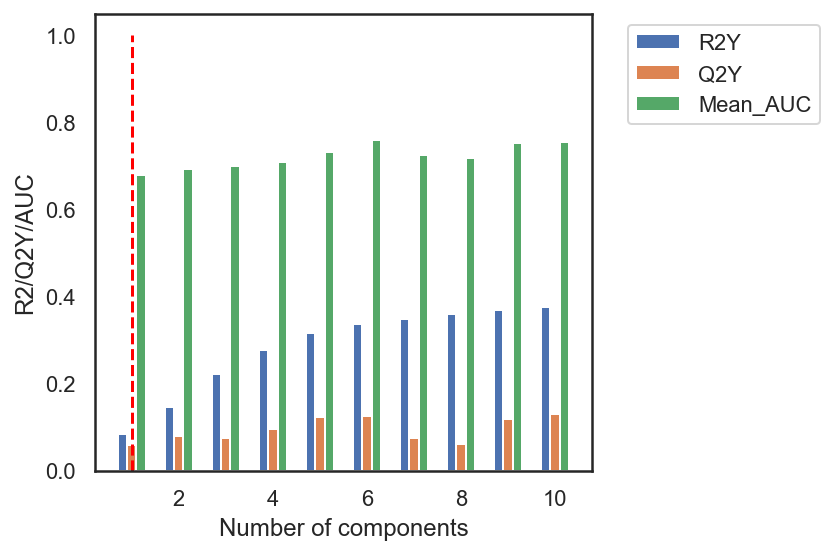

In [100]:
pls_da.scree_plot(X_centered, grp.to_numpy(), total_comps=10);

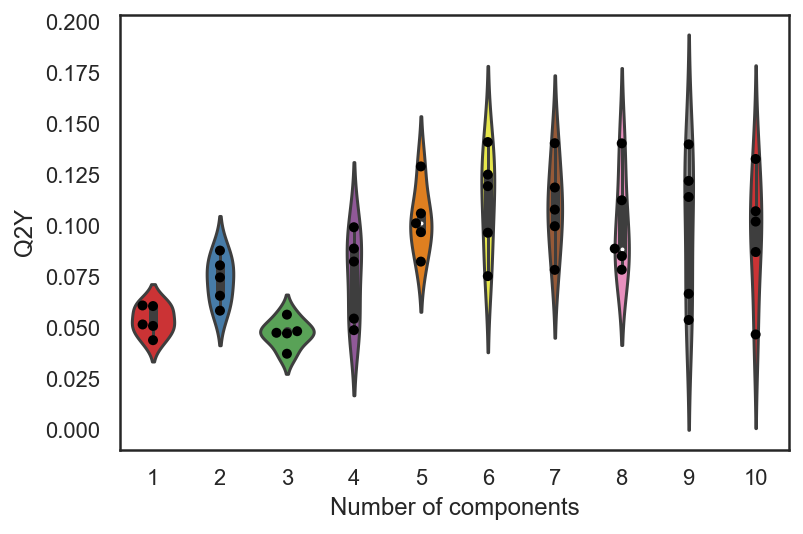

In [101]:
# Repeated cross_validation
rep_cv = pls_da.repeated_cv(X_centered, grp.to_numpy(), repeats=5, total_comps=10)

Refit model

In [102]:
# Create and fit Orthogonal PLS-DA model
# components = 2.
orthogonal_pls_da = ChemometricsOrthogonalPLSDA(ncomps=2, xscaler=None)
#pls_da = ChemometricsPLSDA(n_components=2, x_scaler=None)
orthogonal_pls_da.fit(X_centered, grp.to_numpy())

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


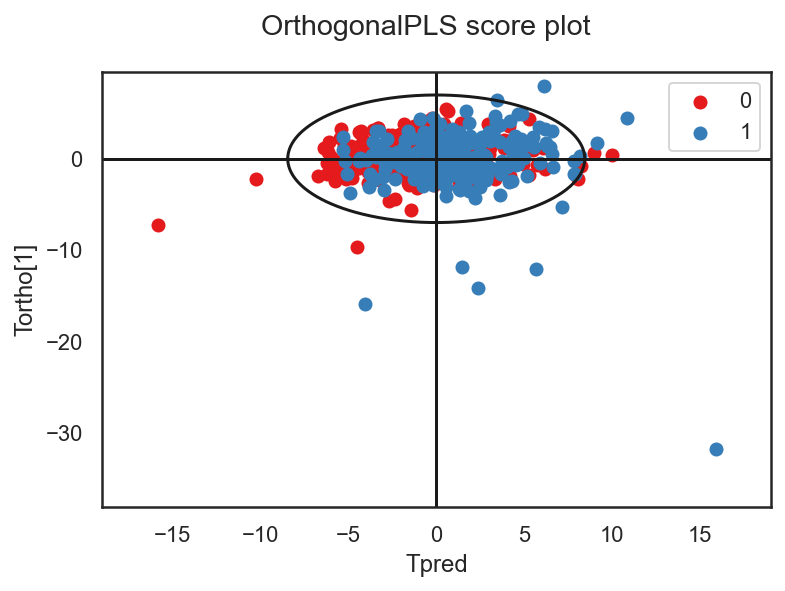

In [103]:
orthogonal_pls_da.plot_scores(color=grp.to_numpy(), discrete=True);

There are no obvious difference between DKO and Control  observing the score plot of OPLS-DA.

### [Go to Table of Contents](#0) <br>

## 6. Some Code References
<a id='6'></a>

 - [Matplotlib specifying colors](https://matplotlib.org/stable/tutorials/colors/colors.html)
 - [hvplot user guide](https://hvplot.holoviz.org/user_guide/index.html)
 - [A video tutorial on hvplot](https://www.youtube.com/watch?v=am0iMNa9-1M)<br>
 - [hvplot implementation computational essay](https://coderzcolumn.com/tutorials/data-science/how-to-convert-static-pandas-plot-matplotlib-to-interactive-hvplot)
 -[PCA visualization via plotly](https://plotly.com/python/pca-visualization/)
 - [UMAP and tSNE via plotly](https://plotly.com/python/t-sne-and-umap-projections/) 
 - [Plotly clustered heatmap (with dendrogram)/Python]( https://stackoverflow.com/questions/66547583/plotly-clustered-heatmap-with-dendrogram-python)
 - [Clustering model comparison with plotly](https://www.kaggle.com/agustinpugliese/clustering-model-comparison-with-plotly)
 - [Extract Clusters from Python Dendrogram](https://nbviewer.org/gist/vals/150ec97a5b7db9c82ee9#Extract-Clusters-from-Python-Dendrogram)
 - [Hierarchical Clustering: Extract observations from large heatmap](https://datascience.stackexchange.com/questions/61417/hierarchical-clustering-extract-observations-from-large-heatmap)

### [Go to Table of Contents](#0) <br>